In [1]:
# poc: mlrosewin@gmail.com
# file: xgboost_forecast_sunspots.ipynb
# date created: jan 2021
# last update: jan 2021

### Imports

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

### Data Ingest

In [3]:
df = pd.read_csv('./data/data_sunspots.csv')
df.columns = ['Date', 'Sunspots']
df['Date'] = pd.to_datetime(df['Date'])

print(df.shape)
print(df.columns)
display(df.head(3))
display(df.tail(3))

(3252, 2)
Index(['Date', 'Sunspots'], dtype='object')


,Date,Sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7


,Date,Sunspots
3249,2019-10-31,0.4
3250,2019-11-30,0.5
3251,2019-12-31,1.6


The dataset starts in January 1749 and stretches to December 2019, 3251 measurements over 271 years. 

### Basic Visualization

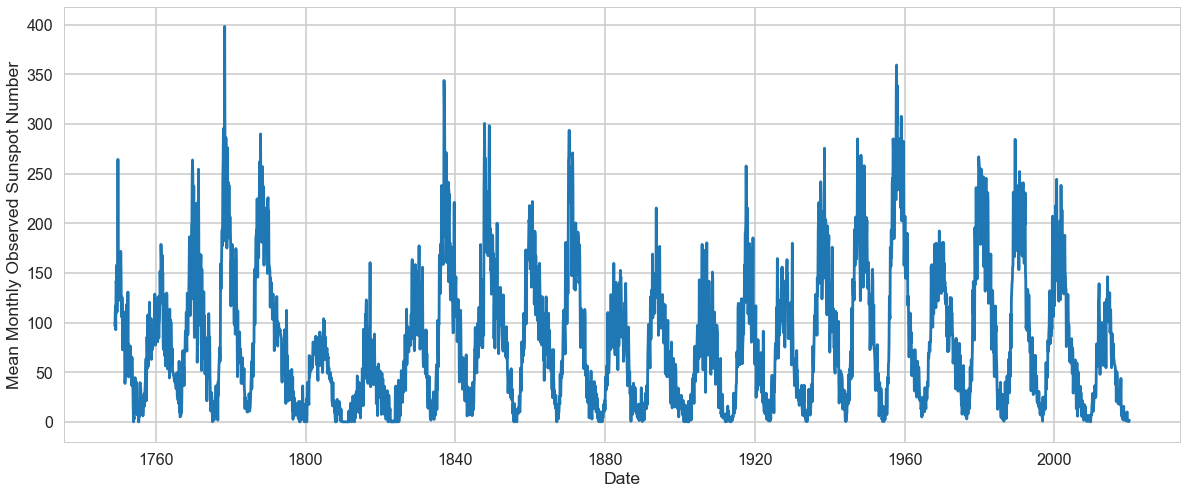

In [4]:
plt.figure(figsize=(20,8))
plt.style.use('seaborn-poster')
plt.style.use('seaborn-whitegrid')
plt.plot(df['Date'], df['Sunspots']); 
plt.xlabel('Date');
plt.ylabel('Mean Monthly Observed Sunspot Number');

### Train and Test Data Creation

In [5]:
#df_train = df.loc[pd.to_datetime('1749-01-31'):pd.to_datetime('1929-12-31')]
#df_train = df.loc['1749-01-31':'1929-12-31']
df_train = df.loc[0:2169]
df_train = df_train.reset_index(drop=True)
df_test = df.loc[2170:3252]
df_test = df_test.reset_index(drop=True)
print(df.shape, df_train.shape, df_test.shape)

(3252, 2) (2170, 2) (1082, 2)


In [35]:
display(df_train.head(3))
display(df_train.tail(3))
display(df_test.head(3))
display(df_test.tail(3))

,Date,Sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7


,Date,Sunspots
2167,1929-08-31,109.6
2168,1929-09-30,57.3
2169,1929-10-31,90.1


,Date,Sunspots
0,1929-11-30,135.1
1,1929-12-31,179.9
2,1930-01-31,108.8


,Date,Sunspots
1079,2019-10-31,0.4
1080,2019-11-30,0.5
1081,2019-12-31,1.6


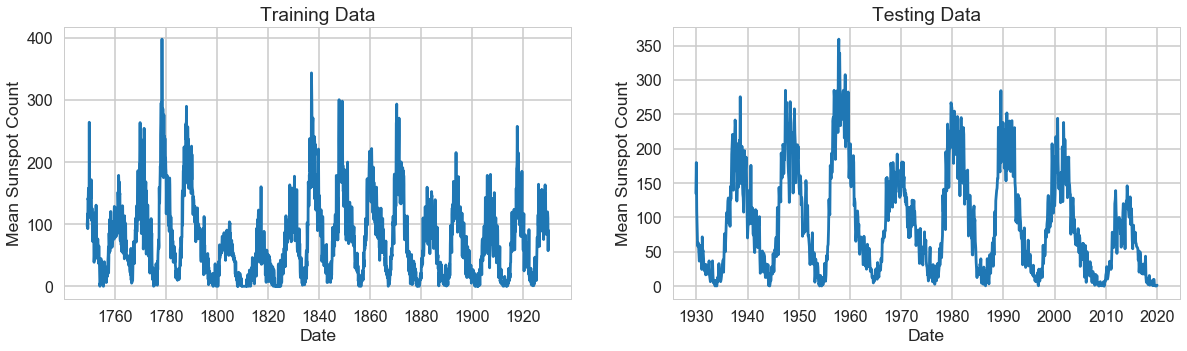

In [7]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(df_train['Date'], df_train['Sunspots'])
plt.xlabel('Date')
plt.ylabel('Mean Sunspot Count')
plt.title('Training Data')

plt.subplot(1,2,2)
plt.plot(df_test['Date'], df_test['Sunspots'])
plt.xlabel('Date')
plt.ylabel('Mean Sunspot Count')
plt.title('Testing Data');

### Regression Dataset Creation

We use a useful function definition from the awesome Jason Brownlee (https://machinelearningmastery.com/) to transform the time series sunspot data into a dataset that a machine learning regression model can be trained on.

In [8]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

We use the previous 500 observations to predict the next sunspot observation. The approximate pattern will repeat every 11 years (132 months), so 500 observations (41.67 years) will encompass several cycles. A better strategy than guessing at this is to treat the window as a hyperparameter and tune it based on model performance. We will explore this topic in a future notebook.

In [9]:
data_train = series_to_supervised(df_train['Sunspots'].to_list(), 100, 1) # 500 # 20
data_test = series_to_supervised(df_test['Sunspots'].to_list(), 100, 1)
print(data_train.shape, data_test.shape)

(2070, 101) (982, 101)


Now we create our X matrix of feature values (consisting in this case of mean counts of sunspots per year) and our y vector (the mean number of sunspots observed in the following year). 

In [10]:
df_train_y = data_train['var1(t)']
df_train_X = data_train.drop(columns=['var1(t)'])
df_test_y = data_test['var1(t)']
df_test_X = data_test.drop(columns=['var1(t)'])

X_train = df_train_X.values
y_train = df_train_y.values
X_test = df_test_X.values
y_test = df_test_y.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Train and Evaluate a Baseline Reference Model

(add words here on why, and features should have, with reference . . . )

In [11]:
X_test

array([[135.1, 179.9, 108.8, ..., 147.9, 164. , 198.6],
       [179.9, 108.8,  83.1, ..., 164. , 198.6, 144.2],
       [108.8,  83.1,  58.4, ..., 198.6, 144.2, 168.4],
       ...,
       [ 56.1,  64.5,  65.8, ...,   0.9,   0.5,   1.1],
       [ 64.5,  65.8, 120.1, ...,   0.5,   1.1,   0.4],
       [ 65.8, 120.1, 125.7, ...,   1.1,   0.4,   0.5]])

In [12]:
df_test_X.head(3)
df_test_X.columns

Index(['var1(t-100)', 'var1(t-99)', 'var1(t-98)', 'var1(t-97)', 'var1(t-96)',
       'var1(t-95)', 'var1(t-94)', 'var1(t-93)', 'var1(t-92)', 'var1(t-91)',
       'var1(t-90)', 'var1(t-89)', 'var1(t-88)', 'var1(t-87)', 'var1(t-86)',
       'var1(t-85)', 'var1(t-84)', 'var1(t-83)', 'var1(t-82)', 'var1(t-81)',
       'var1(t-80)', 'var1(t-79)', 'var1(t-78)', 'var1(t-77)', 'var1(t-76)',
       'var1(t-75)', 'var1(t-74)', 'var1(t-73)', 'var1(t-72)', 'var1(t-71)',
       'var1(t-70)', 'var1(t-69)', 'var1(t-68)', 'var1(t-67)', 'var1(t-66)',
       'var1(t-65)', 'var1(t-64)', 'var1(t-63)', 'var1(t-62)', 'var1(t-61)',
       'var1(t-60)', 'var1(t-59)', 'var1(t-58)', 'var1(t-57)', 'var1(t-56)',
       'var1(t-55)', 'var1(t-54)', 'var1(t-53)', 'var1(t-52)', 'var1(t-51)',
       'var1(t-50)', 'var1(t-49)', 'var1(t-48)', 'var1(t-47)', 'var1(t-46)',
       'var1(t-45)', 'var1(t-44)', 'var1(t-43)', 'var1(t-42)', 'var1(t-41)',
       'var1(t-40)', 'var1(t-39)', 'var1(t-38)', 'var1(t-37)', 'var1(t-36)'

In [13]:
df_test_X['var1(t-1)'].values

array([1.986e+02, 1.442e+02, 1.684e+02, 2.123e+02, 1.626e+02, 2.756e+02,
       1.928e+02, 1.493e+02, 1.653e+02, 2.036e+02, 1.547e+02, 1.339e+02,
       1.290e+02, 1.078e+02, 1.819e+02, 1.973e+02, 1.683e+02, 1.626e+02,
       1.763e+02, 1.877e+02, 1.469e+02, 1.137e+02, 7.020e+01, 8.410e+01,
       9.910e+01, 1.389e+02, 1.011e+02, 9.060e+01, 1.398e+02, 1.125e+02,
       1.759e+02, 1.108e+02, 9.150e+01, 9.740e+01, 1.138e+02, 7.610e+01,
       7.430e+01, 7.750e+01, 5.460e+01, 4.900e+01, 9.960e+01, 1.114e+02,
       1.001e+02, 1.098e+02, 7.720e+01, 6.400e+01, 5.620e+01, 5.950e+01,
       8.790e+01, 9.040e+01, 1.012e+02, 4.180e+01, 1.890e+01, 2.960e+01,
       3.370e+01, 2.870e+01, 3.200e+01, 5.130e+01, 3.760e+01, 2.070e+01,
       4.810e+01, 4.570e+01, 4.350e+01, 2.360e+01, 1.270e+01, 2.200e+01,
       3.230e+01, 1.670e+01, 1.300e+01, 1.700e+01, 3.140e+01, 6.100e+00,
       8.000e-01, 1.830e+01, 4.000e-01, 4.100e+00, 8.200e+00, 8.500e+00,
       2.790e+01, 2.370e+01, 2.810e+01, 1.790e+01, 

In [15]:
predictions = pd.DataFrame(y_test)

y_pred_baseline = df_test_X['var1(t-1)'].values
predictions['baseline'] = y_pred_baseline

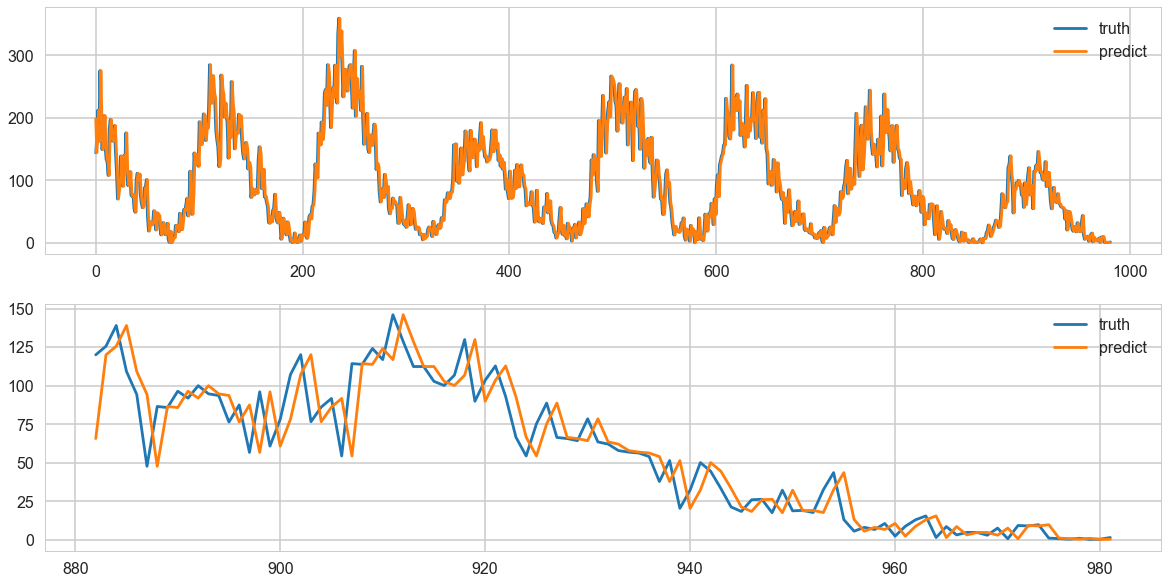

In [16]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['baseline'], label='predict')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='truth')
plt.plot(predictions['baseline'].tail(100), label='predict')
plt.legend()

In [25]:
mean_squared_error(y_test, y_pred_baseline) 

732.378716904277

### Train and Evaluate a Gradient Boosted Regressor Model

We set the number of trees (n_estimators) and the maximum depth of a given tree in the ensemble (max_depth) by hand (we will dive in on hyperparameter tuning strategies in a future notebook) and train a gradient boosted tree regression model from the scikit-learn library. The reason we 
name the model 'mid_model' will become clear later in the notebook.

In [17]:
# hyperparameters
N_ESTIMATORS = 100
MAX_DEPTH = 5

# create model
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

# train model
mid_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5)

In [18]:
# model evaluation

predictions = pd.DataFrame(y_test)
y_pred = mid_model.predict(X_test)
predictions['mid'] = y_pred
predictions.head()

,0,mid
0,144.2,205.513925
1,168.4,149.184460
2,212.3,157.999470
3,162.6,165.808678
4,275.6,157.711167


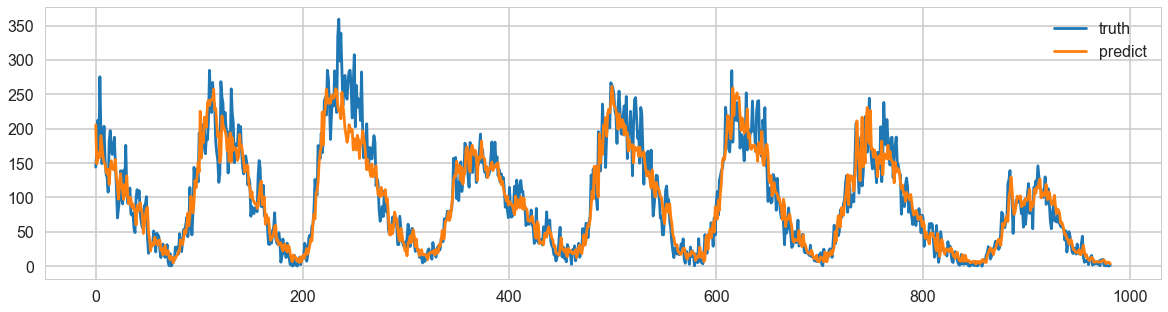

In [19]:
plt.figure(figsize=(20,5))
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['mid'], label='predict')
plt.legend()

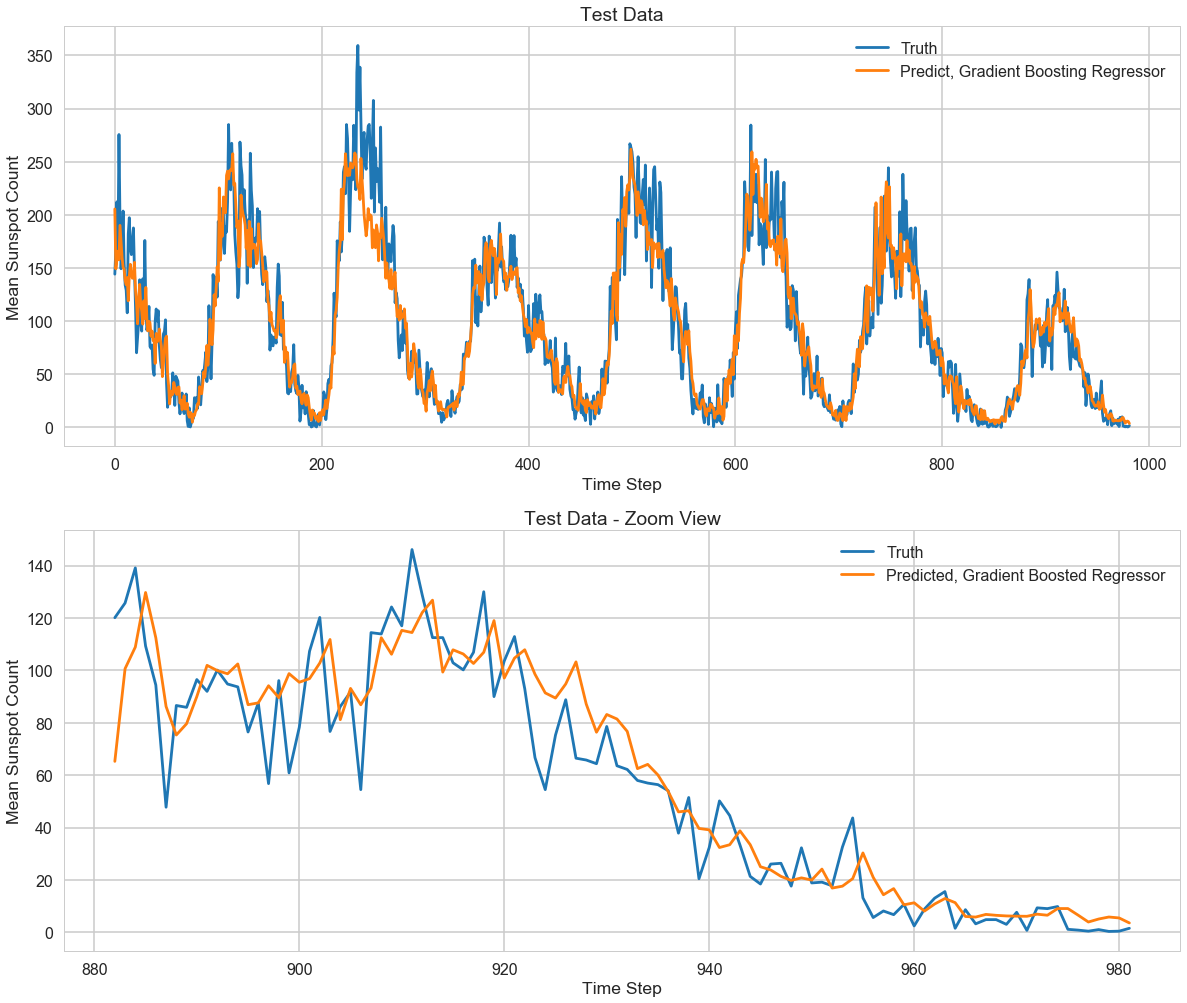

In [34]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,17))
plt.style.use('seaborn-poster')
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='Truth')
plt.plot(predictions['mid'], label='Predict, Gradient Boosting Regressor')
plt.ylabel('Mean Sunspot Count')
plt.xlabel('Time Step')
plt.title('Test Data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='Truth')
plt.plot(predictions['mid'].tail(100), label='Predicted, Gradient Boosted Regressor')
plt.ylabel('Mean Sunspot Count')
plt.xlabel('Time Step')
plt.title('Test Data - Zoom View')
plt.legend();

In [21]:
# mean_squared_error(y_true, y_pred)
mean_squared_error(y_test, y_pred) 

# note: need to have a baseline to beat . . . see chollet baselines!

749.9950427079385

The baseline has a mean squared error of 732, while the xgboost regression model has a mean squared error of 753, so we have not done better than the default yet. We have more work to do. 

(note: look at performance on training set, see if same error being made, predictions decrease too quickly after peak . . . ) (then real cross-val training, and hyperparameter training, and see . . . maybe other boosting . . . oh yhea, this is sklearn, see what xgboost gives !!!)

### XGBoost Regression

In [22]:
#N_ESTIMATORS = 100
#MAX_DEPTH = 5

xgb_r1 = xgb.XGBRegressor(max_depth = MAX_DEPTH, n_estimators=N_ESTIMATORS)
xgb_r1.fit(X_train, y_train)
y_pred_xgb = xgb_r1.predict(X_test)
predictions['xgb'] = y_pred_xgb

### Prediction Intervals via Quantile Regression

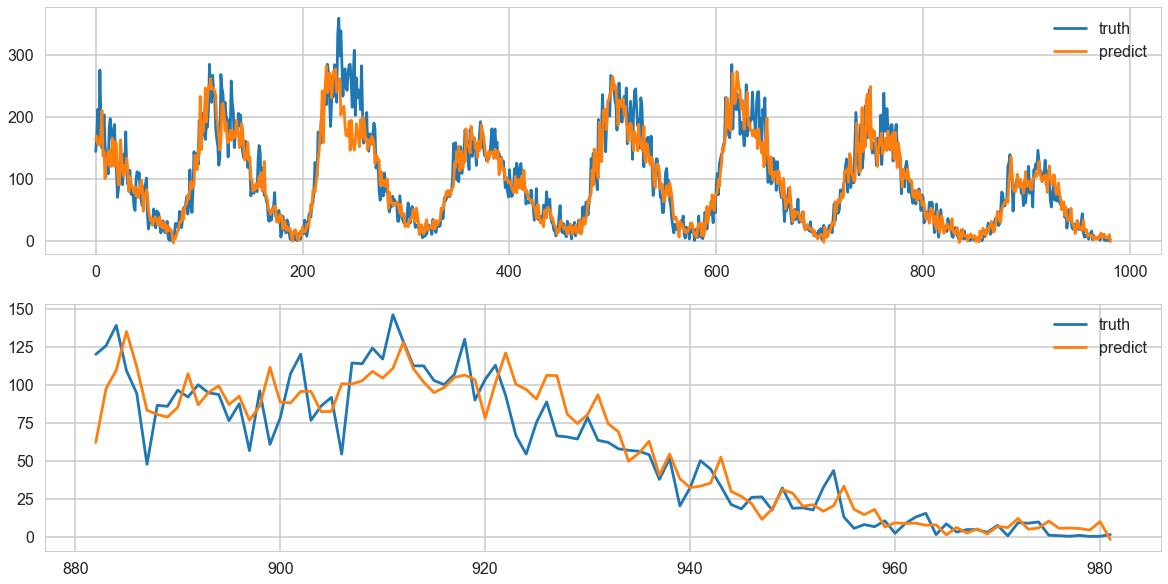

In [23]:
# make a simple function for this, comparing truth to predictions
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
#plt.plot(predictions[0][0:100])
plt.plot(predictions[0], label='truth')
plt.plot(predictions['xgb'], label='predict')
plt.legend()

plt.subplot(2,1,2)
plt.plot(predictions[0].tail(100), label='truth')
plt.plot(predictions['xgb'].tail(100), label='predict')
plt.legend()

In [24]:
mean_squared_error(y_test, y_pred_xgb) 

847.9872839694099

note: And this (xgboost) score is worse still! Ok. Work to do. The points above, and more complex models. Maybe continue here to improve models, and switch xgboost focus to anomaly nb . . . more later. 

Plan: soon, implement coursera cnn_lstm model and see if can beat the reasonable default. Note: might try other defaults also (predict the mean, etc). 